# Quantum Error Correction

[cit. video link](https://www.youtube.com/watch?v=AuDfq7j_W7E&ab_channel=Decodoku)

We can map a unitary error (no energy dissipation) as a linear combination of Pauli Matrices:
We can map a unitary error (no energy dissipation) as a linear combination of Pauli Matrices:

$U = aI + bX + cY + dZ $

where $(a, b, c, d )\in \mathbb{C}$ and $(I, X, Y, Z)$ are the Pauli matrices.

The effect of $(U)$ on a generic state $(\ket{\psi})$ is given by:

$ \ket{\psi '} = U \ket{\psi} = a \ket{\psi} + b X\ket{\psi} + + cY\ket{\psi} + dZ\ket{\psi} $

This represents the transformation of the quantum state under the unitary operation \(U\).

Note that it is a superposition of the different effects of the pauli matrices on $\ket{\psi}$

We can thus try to understand if we have an $X$ error, a $Y$ error or a $Z$ error.

By using the proportionality: $Y \sim XZ$ we can collapse the three errors to the errors given by only two types.

**BIT FLIPS:**

$X \ket{0} = \ket{1}$

$X\ket{1} = \ket{0}$

**PHASE FLIPS:**

$Z\ket{+} = \ket{-}$

$Z\ket{-} = \ket{+}$


## Repetition Code:

we repeat the same message numerous times to mitigate the number of errors and extrapolate the original message.

A way of extrapolating is by choosing the majority voting:

for d repetitions we get 

$ P = \sum^{d/2}_{n=0} \binom{d}{n} p^n (1-p)^{d-n} \sim (\frac{p}{1-p})^{d/2}$

We can see that the probability of misunderstanding the message decays exponentially with the number of repetitions d.

In [37]:
from qiskit import __version__
assert __version__ >= '2.0.0', 'Qiskit version is too low. Upgrade to v2.0.0 or later.'
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram

from qiskit.circuit.classical import expr # for dinamic if statements in the circuit
from qiskit.circuit.classical.expr import Binary

import matplotlib.pyplot as plt

plt.style.use('dark_background')

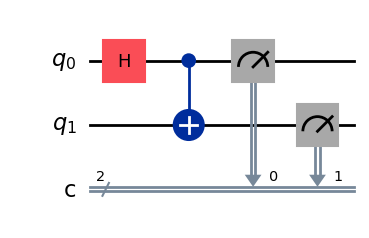

In [38]:
# making a basic quantum circuit
def basic_circuit():

    qr = QuantumRegister(2, 'q')
    cr = ClassicalRegister(2, 'c')
    qc = QuantumCircuit(qr, cr)

    qc.h(qr[0])
    qc.cx(qr[0], qr[1])

    qc.measure(qr, cr)
    return qc

basic_circuit().draw('mpl')

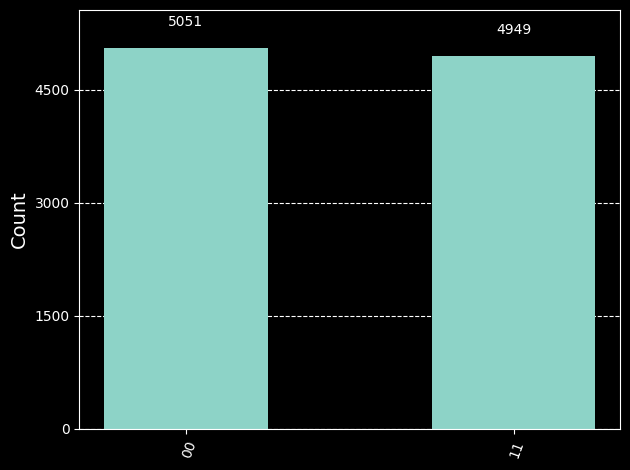

In [39]:
# simulation of the circuit without errors
from qiskit_aer import AerSimulator

sim = AerSimulator(method='statevector')
qc = basic_circuit()
qc_sim = transpile(qc, sim)

job = sim.run(qc_sim, shots=10000)
result = job.result()
counts = result.get_counts(qc_sim)

plot_histogram(counts)

In the local simulation there is no error, so the outcomes rapresent the ideal circuit behaviour.

Let's try to run it on a real backend

In [40]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


service = QiskitRuntimeService(channel='ibm_quantum')


least_busy = service.least_busy(operational=True, min_num_qubits=5)
print(f"Using backend: {least_busy}")

# Generate a pass manager
pass_manager = generate_preset_pass_manager(
    optimization_level=0,
    backend=least_busy
)

# transpile the circuit with the pass manager
qc_transpiled = pass_manager.run(qc)

Using backend: <IBMBackend('ibm_kyiv')>


In [41]:
if 0:
    sampler = Sampler(mode=least_busy)

    job = sampler.run([qc_transpiled]*10, shots=10000)
    print(f"Sampler job ID: {job.job_id()}")
    job_id = job.job_id()

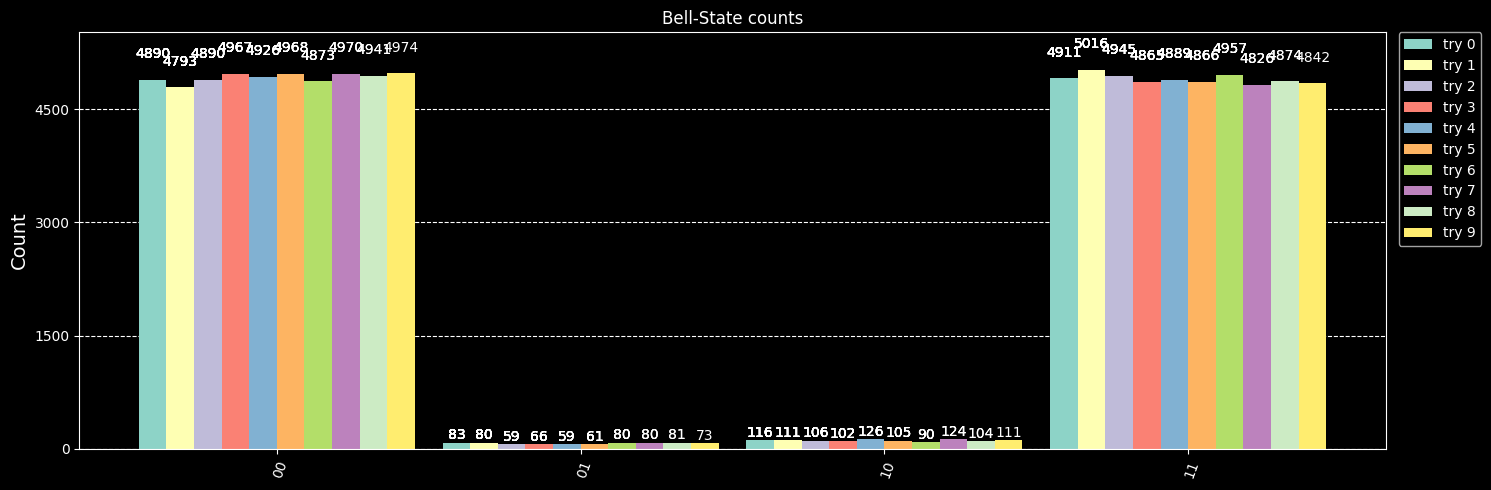

In [42]:
job_id = "czx7bnpqnmvg008vyx7g"

results = service.job(job_id).result()

results = [i.data.c.get_counts() for i in results]

plot_histogram(results, title='Bell-State counts', figsize=(15, 5), legend=[f"try {i}" for i in range(len(results))])

We can clearly see that we get an ammount of error for every try that could not happen in the normal algorithm. The states $\ket{01} \otimes \ket{10}$ are not possible states of the system unless we get a bit flip error!

Also note that by running the circuits on a very high number of shots we can clearly distinguish the error part and the actual outcome of the algorithm.

## Using Parity

We neeed a way to measure the error in the qubits but if we directly apply a measure we **collapse the state!!** witch is problematical for the algorithms.

So we need a way to measure only the essential informations for the error correction of the state without comprimising it.

For this we can use the parity of the bell states:

### See the problem

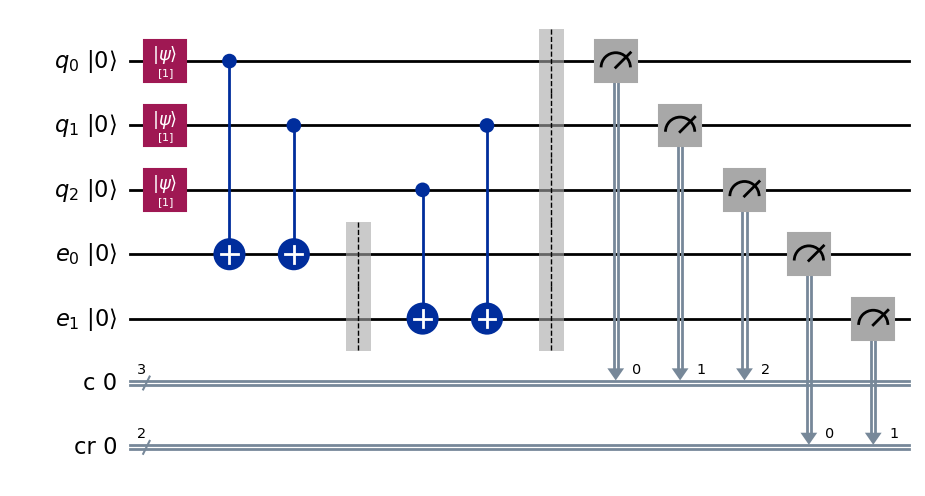

In [43]:
def qc_parity_err(init_state:str='000'):

    actual_qbits = QuantumRegister(3, 'q')

    error_qbits = QuantumRegister(2, 'e')

    cr_qb = ClassicalRegister(3, 'c')
    cr_err = ClassicalRegister(2, 'cr')

    qc = QuantumCircuit(actual_qbits, error_qbits, cr_qb, cr_err)

    qc.initialize(init_state[0], actual_qbits[0])
    qc.initialize(init_state[1], actual_qbits[1])
    qc.initialize(init_state[2], actual_qbits[2])

    qc.cx(actual_qbits[0], error_qbits[0])
    qc.cx(actual_qbits[1], error_qbits[0])

    qc.barrier(error_qbits)

    qc.cx(actual_qbits[2], error_qbits[1])
    qc.cx(actual_qbits[1], error_qbits[1])

    qc.barrier()

    qc.measure(actual_qbits[0], cr_qb[0])
    qc.measure(actual_qbits[1], cr_qb[1])
    qc.measure(actual_qbits[2], cr_qb[2])
    qc.measure(error_qbits[0], cr_err[0])
    qc.measure(error_qbits[1], cr_err[1])

    return qc

qc_parity_err('111').draw('mpl', initial_state=True)

Suppose we have an initial state for a logical qubit as $\ket{0}$ that we duplicate in the code with 3 actual qbits in $\ket{000}$

we can simulate the bit flip due to errors in the system by setting manually the initial state as [ $ \ket{000}, \ket{001}, \ket{011}, \ket{111} $ ]

so with 0, 1, 2, 3 bit flip errors

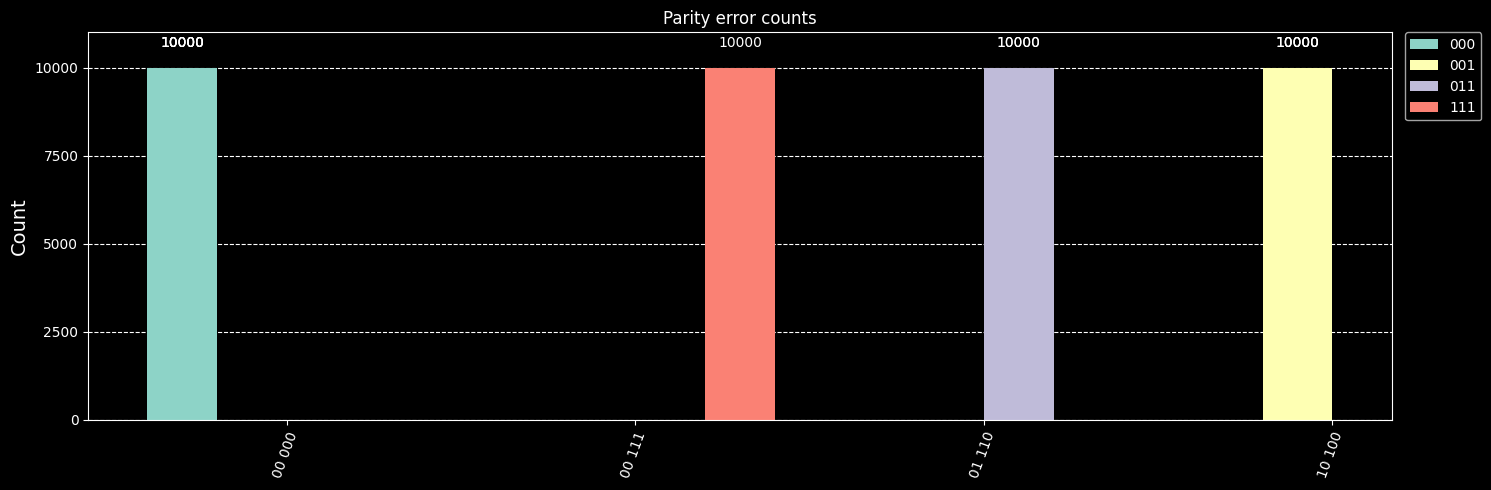

In [ ]:
sim = AerSimulator(method='statevector')

init_states = ['000', '001', '011', '111']

qc_list = [qc_parity_err(init_state) for init_state in init_states]
qc_trans_list = [transpile(qc, sim) for qc in qc_list]

job = sim.run(qc_trans_list, shots=10000)
result = job.result()

plot_histogram(result.get_counts(), title='Parity alg', figsize=(15, 5), legend=init_states)

It is clear that the parity measurement returns no error in state $\ket{000}$ and $\ket{111}$ since the measurements for the 2 error qbits are 00.

On the other hand $\ket{001}$ and $\ket{011}$ give rise to a parity flip witch we can use to correct the errors.

### Error Correction

[IBM video for dinamic circuits](https://www.youtube.com/watch?v=QLMVfImNc0o&ab_channel=Qiskit)

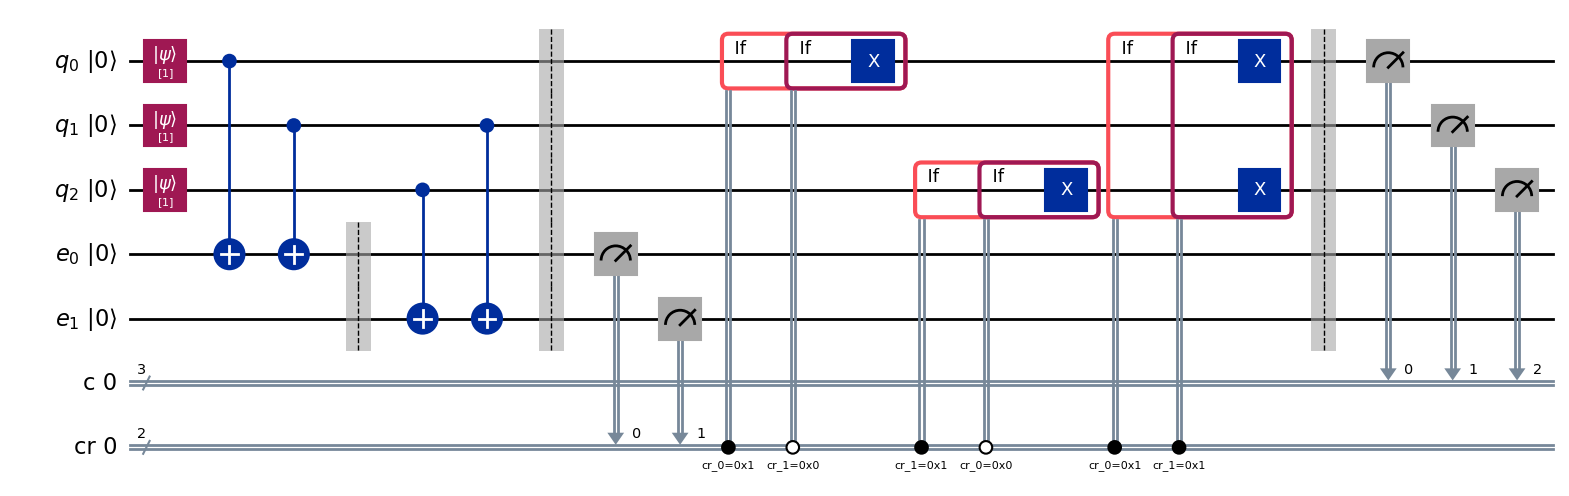

In [45]:
def qc_parity_err_corrected(init_state:str='000'):

    actual_qbits = QuantumRegister(3, 'q')

    error_qbits = QuantumRegister(2, 'e')

    cr_qb = ClassicalRegister(3, 'c')
    cr_err = ClassicalRegister(2, 'cr')

    qc = QuantumCircuit(actual_qbits, error_qbits, cr_qb, cr_err)

    qc.initialize(init_state[0], actual_qbits[0])
    qc.initialize(init_state[1], actual_qbits[1])
    qc.initialize(init_state[2], actual_qbits[2])

    qc.cx(actual_qbits[0], error_qbits[0])
    qc.cx(actual_qbits[1], error_qbits[0])

    qc.barrier(error_qbits)

    qc.cx(actual_qbits[2], error_qbits[1])
    qc.cx(actual_qbits[1], error_qbits[1])

    qc.barrier()

    qc.measure(error_qbits[0], cr_err[0])
    qc.measure(error_qbits[1], cr_err[1])

    with qc.if_test((cr_err[0], 1)):
        with qc.if_test((cr_err[1], 0)):
            qc.x(actual_qbits[0])

    with qc.if_test((cr_err[1], 1)):
        with qc.if_test((cr_err[0], 0)):
            qc.x(actual_qbits[2])

    with qc.if_test((cr_err[0], 1)):
        with qc.if_test((cr_err[1], 1)):
            qc.x(actual_qbits[2])
            # qc.x(actual_qbits[1])
            qc.x(actual_qbits[0])
    
    
    qc.barrier()

    qc.measure(actual_qbits[0], cr_qb[0])
    qc.measure(actual_qbits[1], cr_qb[1])
    qc.measure(actual_qbits[2], cr_qb[2])

    return qc

qc_parity_err_corrected('111').draw('mpl', initial_state=True)

initial states:  ['000', '001', '100', '101']


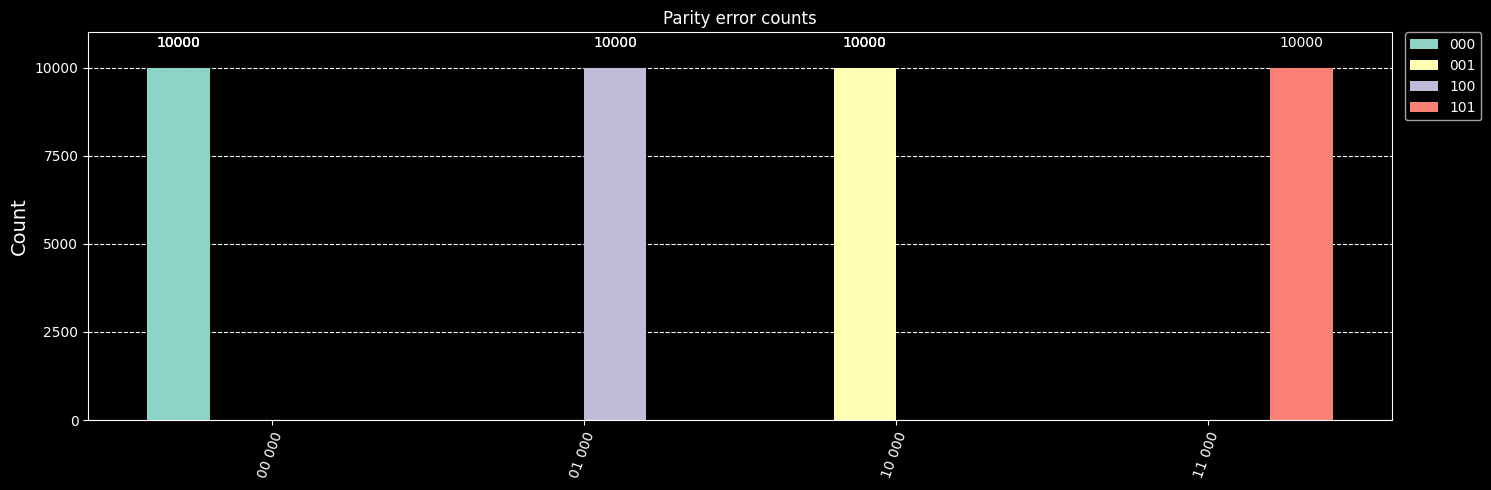

In [46]:
sim = AerSimulator(method='statevector')

# init_states = [f'{a}{b}{c}' for a in '01' for b in '01' for c in '01']
init_states = ['000', '001', '100', '101']

print("initial states: ", init_states)

qc_list = [transpile(qc_parity_err_corrected(init_state), sim) for init_state in init_states]

job = sim.run(qc_list, shots=10000, dynamic=True)
result = job.result()

plot_histogram(result.get_counts(), title='Parity error counts', figsize=(15, 5), legend=init_states)

The errors get corrected accordingly but note that if the middle bit flips it causes errors

Problems:

this type of correction is usefull for bitflips and the implementation of quantum gates is done by applying the same gate to all the actual qubits but it becomes problematic when using entagled states with CNOT Gates!!